In [1]:
import vtk
from vtk.util.numpy_support import vtk_to_numpy
import numpy as np

In [2]:
# Parameters
num_samples = 2000  # Number of samples per grid point
num_bins = 10  # Number of bins for histograms
vti_file_path = "/kaggle/input/gaussian-data/Teardrop_Gaussian.vti"  
output_file = "histogram_dataset.npz"  

In [3]:
# Step 1: Read the .vti file
reader = vtk.vtkXMLImageDataReader()
reader.SetFileName(vti_file_path)
reader.Update()

data = reader.GetOutput()
pdata = data.GetPointData()
n_pts = data.GetNumberOfPoints()
dim = data.GetDimensions()
n_dim = len(dim)

print(f"n_pts: {n_pts}, dim: {dim}, n_dim: {n_dim}")

n_pts: 262144, dim: (64, 64, 64), n_dim: 3


In [4]:
# Step 2: Extract mean and standard deviation arrays
mean_array = vtk_to_numpy(pdata.GetArray("Average"))  
std_array = vtk_to_numpy(pdata.GetArray("Standard_Deviation"))  

assert mean_array.shape[0] == n_pts, "Mismatch between number of points and mean array size."
assert std_array.shape[0] == n_pts, "Mismatch between number of points and std array size."

In [5]:
# # Step 3: Reshape mean and std arrays to 3D
# mean_array = mean_array.reshape(dim)  # Shape: (dim_x, dim_y, dim_z)
# std_array = std_array.reshape(dim)  # Shape: (dim_x, dim_y, dim_z)
# Prepare dataset storage
histograms = np.zeros((n_pts, num_bins), dtype=np.int32)  # Store histogram frequencies (counts)
coordinates = np.zeros((n_pts, n_dim), dtype=np.float32)  # Store 3D coordinates

In [6]:
# Step 4: Generate histograms and store coordinates
for i in range(n_pts):
    mean = mean_array[i]
    std = std_array[i]

    # Sample values from the Gaussian distribution
    samples = np.random.normal(mean, std, num_samples)

    # Create histogram (frequencies only, not normalized)
    hist, bin_edges = np.histogram(samples, bins=num_bins)

    # Store histogram frequencies at the grid point
    histograms[i, :] = hist

    # Store corresponding coordinate
    coordinates[i, :] = data.GetPoint(i)  # Extract spatial coordinate from VTI file

# Step 5: Save the dataset
np.savez(output_file, coordinates=coordinates, histograms=histograms)

print(f"Histogram dataset saved to {output_file}")

Histogram dataset saved to histogram_dataset.npz


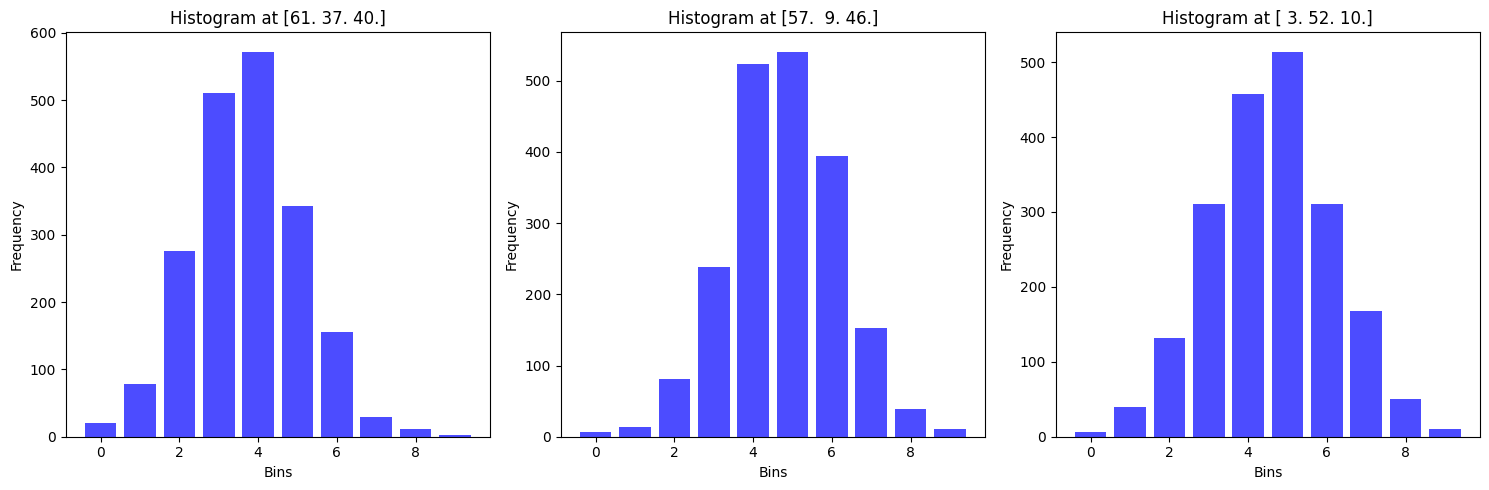

In [7]:
import matplotlib.pyplot as plt
import random

# Load dataset
data = np.load("histogram_dataset.npz")
coordinates = data["coordinates"]  # (n_pts, 3)
histograms = data["histograms"]  # (n_pts, num_bins)
num_bins = histograms.shape[1]

# Select a few random grid points to visualize
num_samples_to_plot = 3  # Adjust for more/less plots
random_indices = random.sample(range(len(coordinates)), num_samples_to_plot)

# Plot histograms for selected grid points
fig, axes = plt.subplots(1, num_samples_to_plot, figsize=(15, 5))

for i, idx in enumerate(random_indices):
    bins = np.arange(num_bins)  # Just bin indices for plotting
    axes[i].bar(bins, histograms[idx], color='blue', alpha=0.7)
    axes[i].set_title(f"Histogram at {coordinates[idx]}")
    axes[i].set_xlabel("Bins")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# # 3D Scatter Plot to Show Selected Points
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], s=1, alpha=0.2, label="All Points")
# ax.scatter(
#     coordinates[random_indices, 0],
#     coordinates[random_indices, 1],
#     coordinates[random_indices, 2],
#     color="red",
#     s=50,
#     label="Selected Points"
# )
# ax.set_title("3D Grid Points (Selected Points in Red)")
# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")
# ax.legend()
# plt.show()


In [1]:
import vtk
from vtk.util.numpy_support import vtk_to_numpy
import numpy as np

# Parameters
num_samples = 2000  # Number of samples per grid point
num_bins = 10       # Number of bins for histograms
vti_file_path = "/kaggle/input/gaussian-data/Teardrop_Gaussian.vti"  
output_vti_file = "histogram_dataset_converted.vti"

########################################
# Step 1: Read the Input VTI File
########################################

reader = vtk.vtkXMLImageDataReader()
reader.SetFileName(vti_file_path)
reader.Update()
data = reader.GetOutput()

n_pts = data.GetNumberOfPoints()
dim = data.GetDimensions()   # Structured grid dimensions (nx, ny, nz)
print(f"Number of points: {n_pts}, Dimensions: {dim}")

# Extract point data arrays for Gaussian parameters ("Average" and "Standard_Deviation")
pdata = data.GetPointData()
mean_array = vtk_to_numpy(pdata.GetArray("Average"))
std_array = vtk_to_numpy(pdata.GetArray("Standard_Deviation"))

assert mean_array.shape[0] == n_pts, "Mismatch between number of points and mean array size."
assert std_array.shape[0] == n_pts, "Mismatch between number of points and std array size."

########################################
# Step 2: Generate Histograms for Each Grid Point
########################################

# Prepare storage for histogram data: one 10-component vector per point
histograms = np.zeros((n_pts, num_bins), dtype=np.int32)

# Loop over each point to generate its histogram from a Gaussian distribution
for i in range(n_pts):
    mean = mean_array[i]
    std = std_array[i]
    # Draw samples from the Gaussian distribution
    samples = np.random.normal(mean, std, num_samples)
    # Compute histogram counts with specified number of bins
    hist, _ = np.histogram(samples, bins=num_bins)
    histograms[i, :] = hist

########################################
# Step 3: Create New VTI File with 10 Separate Variables
########################################

# Create a new vtkImageData object using the same grid dimensions as the input.
imageData = vtk.vtkImageData()
imageData.SetDimensions(dim)

# Set the origin and spacing to match the input data (assumes structured grid)
origin = data.GetOrigin()
spacing = data.GetSpacing()
imageData.SetOrigin(origin)
imageData.SetSpacing(spacing)
print(f"Origin: {origin}, Spacing: {spacing}")

# For each histogram bin, create a separate vtkIntArray and fill it with the bin counts.
for bin_idx in range(num_bins):
    # Create a VTK array for this bin
    bin_array = vtk.vtkIntArray()
    bin_array.SetNumberOfComponents(1)
    bin_array.SetNumberOfTuples(n_pts)
    # Name the array as "bin1", "bin2", ..., "bin10"
    bin_name = f"bin{bin_idx+1}"
    bin_array.SetName(bin_name)
    
    # Fill the array with the counts for this bin from all grid points.
    for i in range(n_pts):
        # Each point gets a single integer value from the histogram for the current bin.
        bin_array.SetTuple1(i, int(histograms[i, bin_idx]))
    
    # Add this bin array to the point data of the vtkImageData
    imageData.GetPointData().AddArray(bin_array)

########################################
# Step 4: Write the New VTI File
########################################

writer = vtk.vtkXMLImageDataWriter()
writer.SetFileName(output_vti_file)
writer.SetInputData(imageData)
writer.Write()

print(f"Converted VTI file saved as '{output_vti_file}'")


Number of points: 262144, Dimensions: (64, 64, 64)
Origin: (0.0, 0.0, 0.0), Spacing: (1.0, 1.0, 1.0)
Converted VTI file saved as 'histogram_dataset_converted.vti'
